In [1]:
import torch.utils.data
import random
from os import path
import numpy as np
import torch
import torchvision.transforms as transforms
import dataloaders
from matplotlib import pyplot as plt
import torchvision.utils as vutils

from networks import dcgan
from networks import wdcgan_gp
from networks import sndcgan
from networks import rdcgan
from networks import cdcgan
from networks import wcdcgan_gp
from networks import sncdcgan
from networks import rcdcgan

from networks.utils import compute_kid_score
from networks.utils import plot_grid
from sample_and_visualize import sample_and_visualize

In [2]:
USE_CUDA = True
if USE_CUDA and torch.cuda.is_available():
    device = 'cuda'  #alt: "cuda:0"
else:
    device = 'cpu'

PIN_MEMORY = True
USE_MULTI_PROCESS_DATA_LOADING = True
if USE_MULTI_PROCESS_DATA_LOADING:
    NUM_THREADS = torch.get_num_threads()
    print("Number of Threads: ", NUM_THREADS)
else:
    NUM_THREADS = 0
    print("Not using Multi-Process Data Loading.")

SEED = 0
random.seed(SEED)
torch.manual_seed(SEED);

### Data
DATA_PATH = path.join("data", "tmdb-64")
TABLE_PATH = path.join("data", "tmdb-movies-220915-clean.pkl")

Number of Threads:  8


In [3]:
### Architecture
IMAGE_SIZE = 64
IMAGE_SIZE_RATIO = 3
NUM_IMG_CHANNELS = 3
NUM_NOISE_VEC_CHANNELS = 100
NUM_FEATURE_VEC_CHANNELS = 37
BASE_NUM_OUT_CHANNELS_G_non_conditional = 64
BASE_NUM_OUT_CHANNELS_G_conditional = 128
BASE_NUM_OUT_CHANNELS_D = 64
D_NORM_LAYER_TYPE = "instance"
PADDING_MODE = "reflect"
COLORMODE="RGB"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Poster subset:
GENRE = None
GENRE_LOGIC = 'and'
OG_LANG = None
YEAR = None
RUNTIME = (40, np.inf)
MAX_NUM = None
SORT = None

BATCH_SIZE = 100
mode = "generated"
iterations = 5
seed = 79469812346923649

genres = ["is_thriller", "is_western", "is_music"]
languages = ["lang_en", "lang_ar", "lang_ja", "lang_zh", "lang_ru"]

In [4]:
poster_dataset = dataloaders.PosterDataset(table_path=TABLE_PATH, img_root_path=DATA_PATH,
                                           img_transform=transforms.Compose([
                                               transforms.ToTensor(),
                                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
                                           colormode=COLORMODE,
                                           img_in_ram=False,
                                           genre=GENRE, genre_logic=GENRE_LOGIC, og_lang=OG_LANG, year=YEAR,
                                           runtime=RUNTIME,
                                           max_num=MAX_NUM, sort=SORT)

posterloader = torch.utils.data.DataLoader(poster_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_THREADS,
                                           pin_memory=PIN_MEMORY)

In [5]:
import pickle
import glob
def evaluate_kid(model_name, model_dir, generator, conditional=False):
    print(model_name)
    models = [model for model in glob.glob(f"{model_dir}/*.pt")]
    num_features = None
    if conditional:
        num_features = NUM_FEATURE_VEC_CHANNELS
    print("KID score:\n")
    means = []
    stds = []
    for model in models:
        print(model)
        generator.load_state_dict(torch.load(model)['generator_model_state_dict'])
        generator.eval()
        mean = compute_kid_score(generator, posterloader, mode, iterations, BATCH_SIZE, NUM_NOISE_VEC_CHANNELS,
                          IMAGE_SIZE_RATIO, device, num_features)
        means.append(mean)
        #stds.append(std)
    kid_scores = {"means": means, "stds": stds}
    with open(path.join(model_dir, f"{model_name}_kid.pkl"), 'wb') as f:
        pickle.dump(kid_scores, f)
    fig = plt.figure(figsize=(10, 5))
    plt.plot(range(len(means)), means)
    plt.show()
    fig.savefig(path.join(model_dir, f"{model_name}_kid.png"))

DCGAN
KID score:

output-runs\dcgan-output\2022-09-26_21-16-09\gan_at_epoch_0000.pt


  0%|          | 0/5 [00:00<?, ?it/s]D:\ProgramData\Anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
100%|██████████| 5/5 [01:09<00:00, 13.98s/it]


Mode: generated | Mean: 0.35590964555740356 | Std: 1.5394257957268564e-07
output-runs\dcgan-output\2022-09-26_21-16-09\gan_at_epoch_0001.pt


100%|██████████| 5/5 [01:06<00:00, 13.39s/it]


Mode: generated | Mean: 0.36917009949684143 | Std: 1.9562428121844277e-07
output-runs\dcgan-output\2022-09-26_21-16-09\gan_at_epoch_0002.pt


100%|██████████| 5/5 [01:06<00:00, 13.33s/it]


Mode: generated | Mean: 0.2520335018634796 | Std: 1.7853241729426372e-07
output-runs\dcgan-output\2022-09-26_21-16-09\gan_at_epoch_0003.pt


100%|██████████| 5/5 [01:06<00:00, 13.35s/it]


Mode: generated | Mean: 0.2863265573978424 | Std: 1.8541484791967378e-07
output-runs\dcgan-output\2022-09-26_21-16-09\gan_at_epoch_0004.pt


100%|██████████| 5/5 [01:06<00:00, 13.33s/it]


Mode: generated | Mean: 0.35736680030822754 | Std: 1.9362425973667996e-07
output-runs\dcgan-output\2022-09-26_21-16-09\gan_at_epoch_0005.pt


100%|██████████| 5/5 [01:47<00:00, 21.54s/it]


Mode: generated | Mean: 0.38818755745887756 | Std: 1.7048260758656397e-07
output-runs\dcgan-output\2022-09-26_21-16-09\gan_at_epoch_0006.pt


100%|██████████| 5/5 [01:06<00:00, 13.29s/it]


Mode: generated | Mean: 0.3864756226539612 | Std: 1.4143026305646345e-07
output-runs\dcgan-output\2022-09-26_21-16-09\gan_at_epoch_0007.pt


100%|██████████| 5/5 [01:07<00:00, 13.45s/it]


Mode: generated | Mean: 0.3991452157497406 | Std: 1.7538852148391015e-07
output-runs\dcgan-output\2022-09-26_21-16-09\gan_at_epoch_0008.pt


100%|██████████| 5/5 [01:07<00:00, 13.42s/it]


Mode: generated | Mean: 0.3972835838794708 | Std: 1.5078428816650558e-07
output-runs\dcgan-output\2022-09-26_21-16-09\gan_at_epoch_0009.pt


100%|██████████| 5/5 [01:06<00:00, 13.38s/it]


Mode: generated | Mean: 0.37741097807884216 | Std: 1.8570247561910946e-07
output-runs\dcgan-output\2022-09-26_21-16-09\gan_at_epoch_0010.pt


100%|██████████| 5/5 [01:05<00:00, 13.12s/it]


Mode: generated | Mean: 0.3788089156150818 | Std: 1.6097399679892987e-07
output-runs\dcgan-output\2022-09-26_21-16-09\gan_at_epoch_0011.pt


100%|██████████| 5/5 [01:05<00:00, 13.03s/it]


Mode: generated | Mean: 0.38822752237319946 | Std: 1.689213178224236e-07
output-runs\dcgan-output\2022-09-26_21-16-09\gan_at_epoch_0012.pt


100%|██████████| 5/5 [01:05<00:00, 13.01s/it]


Mode: generated | Mean: 0.39131462574005127 | Std: 1.7219075232333125e-07
output-runs\dcgan-output\2022-09-26_21-16-09\gan_at_epoch_0013.pt


100%|██████████| 5/5 [01:05<00:00, 13.14s/it]


Mode: generated | Mean: 0.3638051748275757 | Std: 1.79600021965598e-07
output-runs\dcgan-output\2022-09-26_21-16-09\gan_at_epoch_0014.pt


100%|██████████| 5/5 [01:05<00:00, 13.13s/it]


Mode: generated | Mean: 0.38068246841430664 | Std: 1.775845959173239e-07
output-runs\dcgan-output\2022-09-26_21-16-09\gan_at_epoch_0015.pt


100%|██████████| 5/5 [01:05<00:00, 13.07s/it]


Mode: generated | Mean: 0.39202675223350525 | Std: 1.7687577269498433e-07
output-runs\dcgan-output\2022-09-26_21-16-09\gan_at_epoch_0016.pt


100%|██████████| 5/5 [01:05<00:00, 13.09s/it]


Mode: generated | Mean: 0.36507949233055115 | Std: 2.0403354028530885e-07
output-runs\dcgan-output\2022-09-26_21-16-09\gan_at_epoch_0017.pt


100%|██████████| 5/5 [01:06<00:00, 13.27s/it]


Mode: generated | Mean: 0.38587769865989685 | Std: 1.453371254456215e-07
output-runs\dcgan-output\2022-09-26_21-16-09\gan_at_epoch_0018.pt


100%|██████████| 5/5 [01:25<00:00, 17.03s/it]


Mode: generated | Mean: 0.38072633743286133 | Std: 1.7526416229429742e-07
output-runs\dcgan-output\2022-09-26_21-16-09\gan_at_epoch_0019.pt


100%|██████████| 5/5 [01:34<00:00, 18.90s/it]

Mode: generated | Mean: 0.39263486862182617 | Std: 1.6190671203730744e-07


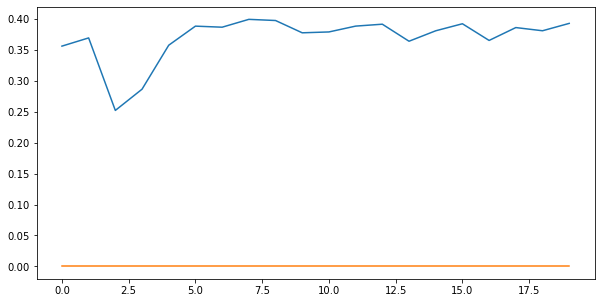

In [6]:
generator, _ = dcgan.create_gan(img_size=IMAGE_SIZE, img_ratio=IMAGE_SIZE_RATIO,
                                            num_img_channels=NUM_IMG_CHANNELS,
                                            num_noise_vec_channels=NUM_NOISE_VEC_CHANNELS,
                                            base_num_out_channels_g=BASE_NUM_OUT_CHANNELS_G_non_conditional,
                                            base_num_out_channels_d=BASE_NUM_OUT_CHANNELS_D, padding_mode=PADDING_MODE,
                                            device=device)
evaluate_kid("DCGAN", "output-runs\\dcgan-output\\2022-09-26_21-16-09", generator, conditional=False)

WDCGAN
KID score:

output-runs\wdcgan-output\2022-09-27_17-05-21\gan_at_epoch_0000.pt


  0%|          | 0/5 [00:00<?, ?it/s]D:\ProgramData\Anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
100%|██████████| 5/5 [01:45<00:00, 21.10s/it]


Mode: generated | Mean: 0.35590964555740356 | Std: 1.5394257957268564e-07
output-runs\wdcgan-output\2022-09-27_17-05-21\gan_at_epoch_0001.pt


100%|██████████| 5/5 [01:13<00:00, 14.69s/it]


Mode: generated | Mean: 0.38357409834861755 | Std: 1.4283371285728208e-07
output-runs\wdcgan-output\2022-09-27_17-05-21\gan_at_epoch_0002.pt


100%|██████████| 5/5 [02:02<00:00, 24.47s/it]


Mode: generated | Mean: 0.37059029936790466 | Std: 1.8610462859669497e-07
output-runs\wdcgan-output\2022-09-27_17-05-21\gan_at_epoch_0003.pt


100%|██████████| 5/5 [01:12<00:00, 14.49s/it]


Mode: generated | Mean: 0.38698217272758484 | Std: 1.6963984705853363e-07
output-runs\wdcgan-output\2022-09-27_17-05-21\gan_at_epoch_0004.pt


100%|██████████| 5/5 [01:10<00:00, 14.17s/it]


Mode: generated | Mean: 0.38347065448760986 | Std: 1.3568879353442753e-07
output-runs\wdcgan-output\2022-09-27_17-05-21\gan_at_epoch_0005.pt


100%|██████████| 5/5 [01:08<00:00, 13.78s/it]


Mode: generated | Mean: 0.38818755745887756 | Std: 1.7048260758656397e-07
output-runs\wdcgan-output\2022-09-27_17-05-21\gan_at_epoch_0006.pt


100%|██████████| 5/5 [01:09<00:00, 13.88s/it]


Mode: generated | Mean: 0.3864680528640747 | Std: 1.6084135268101818e-07
output-runs\wdcgan-output\2022-09-27_17-05-21\gan_at_epoch_0007.pt


100%|██████████| 5/5 [01:12<00:00, 14.47s/it]


Mode: generated | Mean: 0.3991276025772095 | Std: 1.844075399048961e-07
output-runs\wdcgan-output\2022-09-27_17-05-21\gan_at_epoch_0008.pt


100%|██████████| 5/5 [01:12<00:00, 14.43s/it]


Mode: generated | Mean: 0.3967112600803375 | Std: 1.8176140770265192e-07
output-runs\wdcgan-output\2022-09-27_17-05-21\gan_at_epoch_0009.pt


100%|██████████| 5/5 [01:13<00:00, 14.63s/it]

Mode: generated | Mean: 0.3765203654766083 | Std: 2.18680995089926e-07


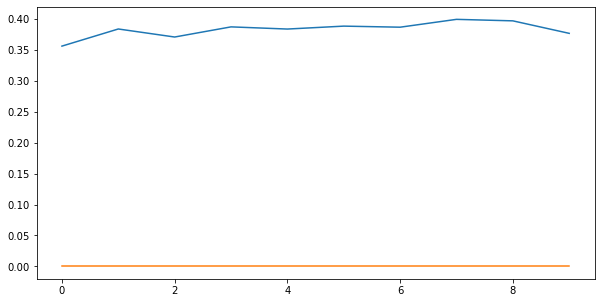

In [6]:
generator, _ = wdcgan_gp.create_gan(num_img_channels=NUM_IMG_CHANNELS,
                                             num_noise_vec_channels=NUM_NOISE_VEC_CHANNELS,
                                             base_num_out_channels_g=BASE_NUM_OUT_CHANNELS_G_non_conditional,
                                             base_num_out_channels_d=BASE_NUM_OUT_CHANNELS_D,
                                             d_norm_layer_type=D_NORM_LAYER_TYPE, padding_mode=PADDING_MODE,
                                             device=device)
evaluate_kid("WDCGAN", "output-runs\\wdcgan-output\\2022-09-27_17-05-21", generator, conditional=False)

SNDCGAN
KID score:

output-runs\sndcgan-output\2022-09-27_15-34-25\gan_at_epoch_0000.pt


100%|██████████| 5/5 [01:45<00:00, 21.06s/it]


Mode: generated | Mean: 0.40827926993370056 | Std: 1.6030594451876823e-07
output-runs\sndcgan-output\2022-09-27_15-34-25\gan_at_epoch_0001.pt


100%|██████████| 5/5 [01:11<00:00, 14.27s/it]


Mode: generated | Mean: 0.40047597885131836 | Std: 2.3006354865628964e-07
output-runs\sndcgan-output\2022-09-27_15-34-25\gan_at_epoch_0002.pt


100%|██████████| 5/5 [01:13<00:00, 14.65s/it]


Mode: generated | Mean: 0.37375789880752563 | Std: 1.4142482029910752e-07
output-runs\sndcgan-output\2022-09-27_15-34-25\gan_at_epoch_0003.pt


100%|██████████| 5/5 [01:11<00:00, 14.30s/it]


Mode: generated | Mean: 0.40262529253959656 | Std: 1.8386640476819593e-07
output-runs\sndcgan-output\2022-09-27_15-34-25\gan_at_epoch_0004.pt


100%|██████████| 5/5 [01:07<00:00, 13.56s/it]

Mode: generated | Mean: 0.3691183030605316 | Std: 2.099783671383193e-07


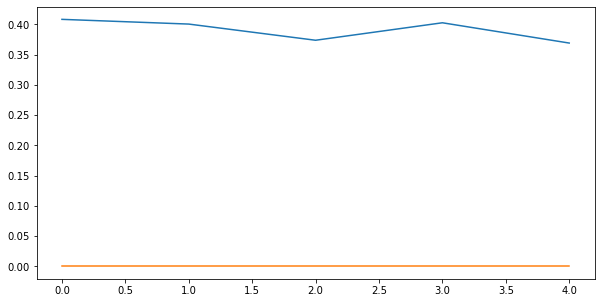

In [7]:
generator, _ = sndcgan.create_gan(num_img_channels=NUM_IMG_CHANNELS,
                                              num_noise_vec_channels=NUM_NOISE_VEC_CHANNELS,
                                              base_num_out_channels_g=BASE_NUM_OUT_CHANNELS_G_non_conditional,
                                              base_num_out_channels_d=BASE_NUM_OUT_CHANNELS_D, padding_mode=PADDING_MODE,
                                              device=device)
evaluate_kid("SNDCGAN", "output-runs\\sndcgan-output\\2022-09-27_15-34-25", generator, conditional=False)

In [ ]:
generator, discriminator = rdcgan.create_gan(img_size=IMAGE_SIZE, img_ratio=IMAGE_SIZE_RATIO,
                                            num_img_channels=NUM_IMG_CHANNELS,
                                            num_noise_vec_channels=NUM_NOISE_VEC_CHANNELS,
                                            base_num_out_channels_g=BASE_NUM_OUT_CHANNELS_G_non_conditional,
                                            base_num_out_channels_d=BASE_NUM_OUT_CHANNELS_D, padding_mode=PADDING_MODE,
                                            device=device)
#evaluate_kid("RaDCGAN", "output-runs\\radcgan-output\\2022-09-25_04-48-49", generator, conditional=False)

cDCGAN
KID score:

output-runs\cdcgan-output\2022-09-27_00-55-04\gan_at_epoch_0000.pt


100%|██████████| 5/5 [01:42<00:00, 20.43s/it]


Mode: generated | Mean: 0.3017929196357727 | Std: 1.780958314157033e-07
output-runs\cdcgan-output\2022-09-27_00-55-04\gan_at_epoch_0001.pt


100%|██████████| 5/5 [03:30<00:00, 42.19s/it]


Mode: generated | Mean: 0.22574250400066376 | Std: 1.6548240466818243e-07
output-runs\cdcgan-output\2022-09-27_00-55-04\gan_at_epoch_0002.pt


100%|██████████| 5/5 [01:36<00:00, 19.38s/it]


Mode: generated | Mean: 0.17755389213562012 | Std: 1.7903788318562874e-07
output-runs\cdcgan-output\2022-09-27_00-55-04\gan_at_epoch_0003.pt


100%|██████████| 5/5 [01:26<00:00, 17.32s/it]


Mode: generated | Mean: 0.20714746415615082 | Std: 1.539365541702864e-07
output-runs\cdcgan-output\2022-09-27_00-55-04\gan_at_epoch_0004.pt


100%|██████████| 5/5 [03:39<00:00, 43.99s/it]


Mode: generated | Mean: 0.24608848989009857 | Std: 1.8887169517256552e-07
output-runs\cdcgan-output\2022-09-27_00-55-04\gan_at_epoch_0005.pt


100%|██████████| 5/5 [01:07<00:00, 13.42s/it]


Mode: generated | Mean: 0.3018511235713959 | Std: 1.7977440336380823e-07
output-runs\cdcgan-output\2022-09-27_00-55-04\gan_at_epoch_0006.pt


100%|██████████| 5/5 [01:12<00:00, 14.46s/it]


Mode: generated | Mean: 0.37915700674057007 | Std: 1.4312963969587145e-07
output-runs\cdcgan-output\2022-09-27_00-55-04\gan_at_epoch_0007.pt


100%|██████████| 5/5 [01:35<00:00, 19.17s/it]


Mode: generated | Mean: 0.3770962655544281 | Std: 1.3893350114813074e-07
output-runs\cdcgan-output\2022-09-27_00-55-04\gan_at_epoch_0008.pt


100%|██████████| 5/5 [01:10<00:00, 14.09s/it]


Mode: generated | Mean: 0.3710706830024719 | Std: 1.9626830294328101e-07
output-runs\cdcgan-output\2022-09-27_00-55-04\gan_at_epoch_0009.pt


100%|██████████| 5/5 [01:18<00:00, 15.65s/it]

Mode: generated | Mean: 0.372052401304245 | Std: 1.7069270086267352e-07


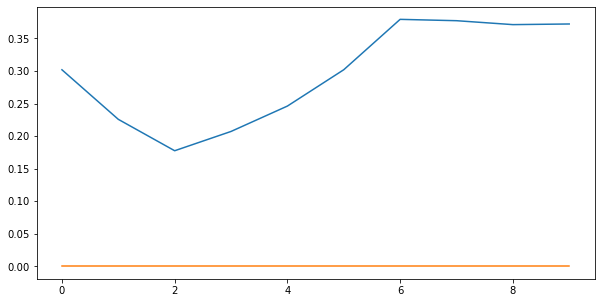

In [10]:
generator, _ = cdcgan.create_gan(num_img_channels=NUM_IMG_CHANNELS,
                                             num_noise_vec_channels=NUM_NOISE_VEC_CHANNELS,
                                             base_num_out_channels_g=BASE_NUM_OUT_CHANNELS_G_conditional,
                                             base_num_out_channels_d=BASE_NUM_OUT_CHANNELS_D, padding_mode=PADDING_MODE,
                                             num_feature_vec_channels=NUM_FEATURE_VEC_CHANNELS, device=device)
evaluate_kid("cDCGAN", "output-runs\\cdcgan-output\\2022-09-27_00-55-04", generator, conditional=True)

WcDCGAN
KID score:

output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0000.pt


100%|██████████| 5/5 [01:09<00:00, 13.83s/it]


Mode: generated | Mean: 0.3894903063774109 | Std: 1.5942502784582757e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0001.pt


100%|██████████| 5/5 [01:07<00:00, 13.58s/it]


Mode: generated | Mean: 0.39487987756729126 | Std: 1.6482972853282263e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0002.pt


100%|██████████| 5/5 [01:11<00:00, 14.23s/it]


Mode: generated | Mean: 0.3456013798713684 | Std: 2.246326857857639e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0003.pt


100%|██████████| 5/5 [01:07<00:00, 13.52s/it]


Mode: generated | Mean: 0.3340485692024231 | Std: 1.9387110228308302e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0004.pt


100%|██████████| 5/5 [01:05<00:00, 13.10s/it]


Mode: generated | Mean: 0.33408740162849426 | Std: 1.8178948835156916e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0005.pt


100%|██████████| 5/5 [01:06<00:00, 13.39s/it]


Mode: generated | Mean: 0.3158624470233917 | Std: 2.2680485756154667e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0006.pt


100%|██████████| 5/5 [01:06<00:00, 13.32s/it]


Mode: generated | Mean: 0.3027982711791992 | Std: 2.043208553459408e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0007.pt


100%|██████████| 5/5 [01:07<00:00, 13.43s/it]


Mode: generated | Mean: 0.30314913392066956 | Std: 1.7968380916499882e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0008.pt


100%|██████████| 5/5 [01:07<00:00, 13.44s/it]


Mode: generated | Mean: 0.3070979118347168 | Std: 1.8937342360914045e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0009.pt


100%|██████████| 5/5 [01:07<00:00, 13.57s/it]


Mode: generated | Mean: 0.26475611329078674 | Std: 2.1929417926003225e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0010.pt


100%|██████████| 5/5 [01:05<00:00, 13.16s/it]


Mode: generated | Mean: 0.30624181032180786 | Std: 1.8461155093518755e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0011.pt


100%|██████████| 5/5 [01:05<00:00, 13.16s/it]


Mode: generated | Mean: 0.26296505331993103 | Std: 2.009137034519881e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0012.pt


100%|██████████| 5/5 [01:07<00:00, 13.42s/it]


Mode: generated | Mean: 0.26596876978874207 | Std: 1.7268234842049424e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0013.pt


100%|██████████| 5/5 [01:05<00:00, 13.15s/it]


Mode: generated | Mean: 0.24758706986904144 | Std: 1.732484378180743e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0014.pt


100%|██████████| 5/5 [01:06<00:00, 13.28s/it]


Mode: generated | Mean: 0.27468934655189514 | Std: 1.8110459620857e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0015.pt


100%|██████████| 5/5 [01:06<00:00, 13.23s/it]


Mode: generated | Mean: 0.27205905318260193 | Std: 1.759616026220101e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0016.pt


100%|██████████| 5/5 [01:07<00:00, 13.53s/it]


Mode: generated | Mean: 0.26774367690086365 | Std: 1.705189021095066e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0017.pt


100%|██████████| 5/5 [01:09<00:00, 13.87s/it]


Mode: generated | Mean: 0.30350029468536377 | Std: 1.6967096883035993e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0018.pt


100%|██████████| 5/5 [01:07<00:00, 13.50s/it]


Mode: generated | Mean: 0.28474757075309753 | Std: 1.876235273812199e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0019.pt


100%|██████████| 5/5 [01:08<00:00, 13.63s/it]


Mode: generated | Mean: 0.3045247495174408 | Std: 1.652987862144073e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0020.pt


100%|██████████| 5/5 [01:21<00:00, 16.34s/it]


Mode: generated | Mean: 0.27599385380744934 | Std: 1.9573091947222565e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0021.pt


100%|██████████| 5/5 [01:07<00:00, 13.47s/it]


Mode: generated | Mean: 0.2731737792491913 | Std: 1.5920466012175893e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0022.pt


100%|██████████| 5/5 [01:08<00:00, 13.72s/it]


Mode: generated | Mean: 0.2958371639251709 | Std: 1.9684033247813204e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0023.pt


100%|██████████| 5/5 [01:06<00:00, 13.30s/it]


Mode: generated | Mean: 0.2834234833717346 | Std: 1.5503069050737395e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0024.pt


100%|██████████| 5/5 [01:06<00:00, 13.38s/it]


Mode: generated | Mean: 0.3173010051250458 | Std: 1.729528520399981e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0025.pt


100%|██████████| 5/5 [01:07<00:00, 13.57s/it]


Mode: generated | Mean: 0.2845759391784668 | Std: 1.9190554212400457e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0026.pt


100%|██████████| 5/5 [01:08<00:00, 13.61s/it]


Mode: generated | Mean: 0.27322450280189514 | Std: 1.9585409916089702e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0027.pt


100%|██████████| 5/5 [01:08<00:00, 13.79s/it]


Mode: generated | Mean: 0.2708006501197815 | Std: 1.9281240781765518e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0028.pt


100%|██████████| 5/5 [01:09<00:00, 13.83s/it]


Mode: generated | Mean: 0.27867454290390015 | Std: 1.60716567165764e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0029.pt


100%|██████████| 5/5 [01:07<00:00, 13.49s/it]


Mode: generated | Mean: 0.26635345816612244 | Std: 2.0015006896301202e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0030.pt


100%|██████████| 5/5 [01:07<00:00, 13.55s/it]


Mode: generated | Mean: 0.31156817078590393 | Std: 1.9101655368558568e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0031.pt


100%|██████████| 5/5 [01:08<00:00, 13.79s/it]


Mode: generated | Mean: 0.3095833957195282 | Std: 2.3047280706123274e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0032.pt


100%|██████████| 5/5 [01:09<00:00, 13.87s/it]


Mode: generated | Mean: 0.3149689733982086 | Std: 1.6166130478723062e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0033.pt


100%|██████████| 5/5 [01:10<00:00, 14.11s/it]


Mode: generated | Mean: 0.3088743984699249 | Std: 1.8634516152360447e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0034.pt


100%|██████████| 5/5 [01:09<00:00, 13.80s/it]


Mode: generated | Mean: 0.2962586581707001 | Std: 1.8768591303341964e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0035.pt


100%|██████████| 5/5 [01:10<00:00, 14.19s/it]


Mode: generated | Mean: 0.26197001338005066 | Std: 1.804247062864306e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0036.pt


100%|██████████| 5/5 [01:06<00:00, 13.39s/it]


Mode: generated | Mean: 0.27217188477516174 | Std: 2.0810965395412495e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0037.pt


100%|██████████| 5/5 [01:07<00:00, 13.41s/it]


Mode: generated | Mean: 0.29226723313331604 | Std: 1.9813485607755865e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0038.pt


100%|██████████| 5/5 [01:06<00:00, 13.23s/it]


Mode: generated | Mean: 0.29613810777664185 | Std: 2.0382314858125028e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0039.pt


100%|██████████| 5/5 [01:09<00:00, 13.91s/it]


Mode: generated | Mean: 0.2932850122451782 | Std: 1.8480713492863288e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0040.pt


100%|██████████| 5/5 [01:19<00:00, 15.90s/it]


Mode: generated | Mean: 0.30687862634658813 | Std: 1.7685113107290817e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0041.pt


100%|██████████| 5/5 [01:20<00:00, 16.07s/it]


Mode: generated | Mean: 0.3176402747631073 | Std: 1.7963111531571485e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0042.pt


100%|██████████| 5/5 [01:08<00:00, 13.74s/it]


Mode: generated | Mean: 0.305352121591568 | Std: 2.0461997962684109e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0043.pt


100%|██████████| 5/5 [01:06<00:00, 13.24s/it]


Mode: generated | Mean: 0.3199472427368164 | Std: 2.0615564721992996e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0044.pt


100%|██████████| 5/5 [01:15<00:00, 15.04s/it]


Mode: generated | Mean: 0.30842360854148865 | Std: 2.0001844802663982e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0045.pt


100%|██████████| 5/5 [01:07<00:00, 13.52s/it]


Mode: generated | Mean: 0.314558207988739 | Std: 1.9236304638070578e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0046.pt


100%|██████████| 5/5 [01:08<00:00, 13.71s/it]


Mode: generated | Mean: 0.306598424911499 | Std: 1.7969300358799956e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0047.pt


100%|██████████| 5/5 [01:08<00:00, 13.63s/it]


Mode: generated | Mean: 0.3309914767742157 | Std: 1.9524377137258853e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0048.pt


100%|██████████| 5/5 [01:07<00:00, 13.41s/it]


Mode: generated | Mean: 0.3143947422504425 | Std: 2.0936666089710343e-07
output-runs\wcdcgan-output\2022-09-25_23-40-46\gan_at_epoch_0049.pt


100%|██████████| 5/5 [01:29<00:00, 17.81s/it]

Mode: generated | Mean: 0.3074997067451477 | Std: 1.6821063297811634e-07


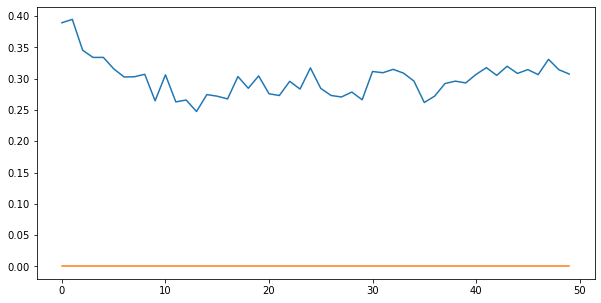

In [12]:
generator, _ = wcdcgan_gp.create_gan(num_img_channels=NUM_IMG_CHANNELS, num_noise_vec_channels=NUM_NOISE_VEC_CHANNELS,
                                    base_num_out_channels_g=BASE_NUM_OUT_CHANNELS_G_conditional,
                                    base_num_out_channels_d=BASE_NUM_OUT_CHANNELS_D, padding_mode=PADDING_MODE,
                                    num_feature_vec_channels=NUM_FEATURE_VEC_CHANNELS,
                                    d_norm_layer_type=D_NORM_LAYER_TYPE, device=device)
evaluate_kid("WcDCGAN", "output-runs\\wcdcgan-output\\2022-09-25_23-40-46", generator, conditional=True)

SNcDCGAN
KID score:

output-runs\sncdcgan-output\2022-09-27_06-53-59\gan_at_epoch_0000.pt


100%|██████████| 5/5 [01:07<00:00, 13.58s/it]


Mode: generated | Mean: 0.3944719731807709 | Std: 1.6405108738126728e-07
output-runs\sncdcgan-output\2022-09-27_06-53-59\gan_at_epoch_0001.pt


100%|██████████| 5/5 [01:13<00:00, 14.64s/it]


Mode: generated | Mean: 0.35606011748313904 | Std: 1.8447302352342376e-07
output-runs\sncdcgan-output\2022-09-27_06-53-59\gan_at_epoch_0002.pt


100%|██████████| 5/5 [01:08<00:00, 13.74s/it]


Mode: generated | Mean: 0.38773152232170105 | Std: 1.8208429253263603e-07
output-runs\sncdcgan-output\2022-09-27_06-53-59\gan_at_epoch_0003.pt


100%|██████████| 5/5 [01:08<00:00, 13.72s/it]


Mode: generated | Mean: 0.3509078919887543 | Std: 1.9499077552609378e-07
output-runs\sncdcgan-output\2022-09-27_06-53-59\gan_at_epoch_0004.pt


100%|██████████| 5/5 [01:08<00:00, 13.68s/it]

Mode: generated | Mean: 0.3562719523906708 | Std: 2.1461924859522696e-07


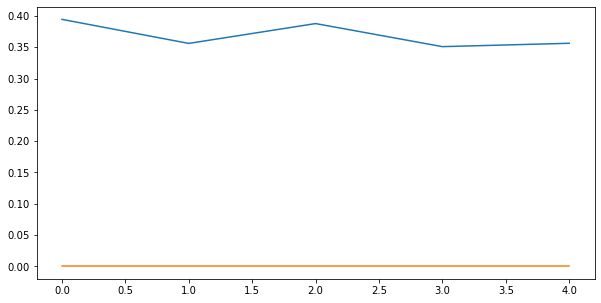

In [11]:
generator, _ = sncdcgan.create_gan(num_img_channels=NUM_IMG_CHANNELS,
                                               num_noise_vec_channels=NUM_NOISE_VEC_CHANNELS,
                                               base_num_out_channels_g=BASE_NUM_OUT_CHANNELS_G_conditional,
                                               base_num_out_channels_d=BASE_NUM_OUT_CHANNELS_D,
                                               padding_mode=PADDING_MODE,
                                               num_feature_vec_channels=NUM_FEATURE_VEC_CHANNELS, device=device)
evaluate_kid("SNcDCGAN", "output-runs\\sncdcgan-output\\2022-09-27_06-53-59", generator, conditional=True)

In [ ]:
generator, _ = rcdcgan.create_gan(img_size=IMAGE_SIZE, img_ratio=IMAGE_SIZE_RATIO,
                                              num_img_channels=NUM_IMG_CHANNELS,
                                              num_noise_vec_channels=NUM_NOISE_VEC_CHANNELS,
                                            num_feature_vec_channels=NUM_FEATURE_VEC_CHANNELS,
                                              base_num_out_channels_g=BASE_NUM_OUT_CHANNELS_G_conditional,
                                              base_num_out_channels_d=BASE_NUM_OUT_CHANNELS_D,
                                              padding_mode=PADDING_MODE,
                                              device=device)
#evaluate_kid("RacDCGAN", "output-runs\\racdcgan-output\\2022-09-25_04-48-49", generator, conditional=True)